In [1]:
import PARSEC_input as par
import subprocess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import matplotlib as mpl
import os
import shutil


In [2]:

def MoveOutputs(Destination):
# Specify the source directory and the destination directory
    source_dir = 'WorkingDir/outputs'
    destination_dir = Destination

# Ensure the destination directory exists, if not, create it
    os.makedirs(destination_dir, exist_ok=True)

# Loop through each file in the source directory and move it
    for filename in os.listdir(source_dir):
    # Create the full file path
        source_file = os.path.join(source_dir, filename)
        destination_file = os.path.join(destination_dir, filename)
    
    # Check if it's a file (skip directories)
        if os.path.isfile(source_file):
        # Move the file
            shutil.move(source_file, destination_file)
            print(f"Moved: {filename}")
    return

In [3]:
ModeRunNumber = 5 #Change for different Modes
Updraft = [0.2,0.5,0.8] #Change for different Updrafts
UpdraftNumber = 2
# Specify the path where you want to create the folder
CCfolder_path = f'/share/pech2273/PARSEC/ECEarth/EC{ModeRunNumber +1}/CC/Updraft{UpdraftNumber+1}'
folder_path = f'/share/pech2273/PARSEC/ECEarth/EC{ModeRunNumber +1}/NoCC/Updraft{UpdraftNumber+1}'
# Create the folder
os.makedirs(folder_path, exist_ok=True)  # 'exist_ok=True' avoids error if the folder already exists
print(f"Folder created at {folder_path}")
os.makedirs(CCfolder_path, exist_ok=True)  # 'exist_ok=True' avoids error if the folder already exists
print(f"Folder created at {folder_path}")
# CoCondensation bug at Mode 6 Updraft 1


Folder created at /share/pech2273/PARSEC/ECEarth/EC6/NoCC/Updraft3
Folder created at /share/pech2273/PARSEC/ECEarth/EC6/NoCC/Updraft3


In [4]:
subprocess.run('scp -r /share/PARSEC/PARSEC-UFO-stockholm/inputs/ /home/pech2273/Nor1', shell = True, check = True)

CompletedProcess(args='scp -r /share/PARSEC/PARSEC-UFO-stockholm/inputs/ /home/pech2273/Nor1', returncode=0)

In [5]:
MassFrac = xr.open_dataset('/share/pech2273/ECMassFracforPARSEC.nc')
Kmeans = xr.open_dataset('/share/pech2273/ECearthKmeans.nc')
Kmeans

<xarray.Dataset> Size: 312B
Dimensions:      (KmeansLabel: 6, Distribution Number: 3)
Dimensions without coordinates: KmeansLabel, Distribution Number
Data variables:
    Dpg          (KmeansLabel, Distribution Number) float64 144B ...
    Ntot         (KmeansLabel, Distribution Number) float64 144B ...
    Temperature  (KmeansLabel) float32 24B ...

In [6]:
Temps  = Kmeans['Temperature']
Modes = Kmeans['Dpg']
Sigmas = [1.5, 1.5, 1.5]
Concs = Kmeans['Ntot']

In [9]:
corrector = sum([np.float64(MassFrac['BCMassFrac'][ModeRunNumber]),np.float64(MassFrac['OAMassFrac'][ModeRunNumber]),np.float64(MassFrac['SO4MassFrac'][ModeRunNumber]),np.float64(MassFrac['DustMassFrac'][ModeRunNumber]),np.float64(MassFrac['SeasaltMassFrac'][ModeRunNumber])])
BCmassCorrected = np.float64(MassFrac['BCMassFrac'][ModeRunNumber])/corrector
OAmassCorrected = np.float64(MassFrac['OAMassFrac'][ModeRunNumber])/corrector
SO4massCorrected = np.float64(MassFrac['SO4MassFrac'][ModeRunNumber])/corrector
SeasaltmassCorrected = np.float64(MassFrac['SeasaltMassFrac'][ModeRunNumber])/corrector
DustmassCorrected = np.float64(MassFrac['DustMassFrac'][ModeRunNumber])/corrector
print(sum([BCmassCorrected,OAmassCorrected,SO4massCorrected,SeasaltmassCorrected,DustmassCorrected]))

1.0


In [10]:

Normode1 = [np.float64(Concs.isel(KmeansLabel = ModeRunNumber)[0]), np.float64(Modes.isel(KmeansLabel = ModeRunNumber)[0]*1E6), Sigmas[0]]
Normode2 = [np.float64(Concs.isel(KmeansLabel = ModeRunNumber)[1]), np.float64(Modes.isel(KmeansLabel = ModeRunNumber)[1]*1E6), Sigmas[1]]
Normode3 = [np.float64(Concs.isel(KmeansLabel = ModeRunNumber)[2]), np.float64(Modes.isel(KmeansLabel = ModeRunNumber)[2]*1E6), Sigmas[2]]
#h2so4, (nh4)hso4, (nh4)2so4, OC, BC, dust, seasalt

In [11]:
NorVarsNoCC= par.PARSEC_UserVars(aerosoldata=[{'Nmodes': 3, 'massfracs': [0, 0, SO4massCorrected, OAmassCorrected, BCmassCorrected, DustmassCorrected, SeasaltmassCorrected, 0], 'mode1': Normode1,\
                                               'mode2': Normode2,'mode3': Normode3}],\
                                   svocdata={'initial_ctot': [ 0.34439296,0.14193628, 0.15926595, 0.14040410, 0.11991960, 0.09408111], 'log_cstar_org': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],\
                                            'min_org_film_thick': 2e-10, 'sigma_org': 30, 'org_sol_frac': 1, 'org_sol_frac_cf': 0, 'org_e_sol_frac_vbs': 1, 'org_densities': 1500,\
                                             'org_mol_mass': 0.2, 'org_vap_enthalpy': 1500000, 'org_alpha': 1},\
                                dynamicsdata = par.dynamicsdata(initial_temperature=np.float32(Temps[ModeRunNumber]),initial_relhum= 90, updraft= Updraft[UpdraftNumber] ),timedata = par.timedata(dt = 1, dtsub = 0.1, time_limit=2000))

In [12]:
CoCondensation = False #Change for CoCondensation
NorinstanceNoCC = par.PARSEC_instance(switches=par.PARSEC_Switches(customaer=0,initflag=1, icondsvocs= CoCondensation), UserVars=NorVarsNoCC, custom_aerosol= None)

In [13]:
NorinstanceNoCC.create_inputs_folder(f'{folder_path}/inputs/', overwrite= True)
NorinstanceNoCC.create_inputs_folder(dir="WorkingDir/inputs/", overwrite= True)


In [14]:
subprocess.run('cd WorkingDir/ && /share/PARSEC/PARSEC-UFO-stockholm/parsec-ufo', shell = True, check = True)

CompletedProcess(args='cd WorkingDir/ && /share/PARSEC/PARSEC-UFO-stockholm/parsec-ufo', returncode=0)

In [15]:
MoveOutputs(folder_path)

Moved: initial_parameters.nc
Moved: basic_parameters.nc
Moved: snap_time-0.nc
Moved: snap_cloudbase.nc
Moved: snap_ssmax.nc
Moved: snap_time-end.nc
Moved: raw_timeseries.nc
Moved: nn_timeseries.nc
Moved: interp_nn_timeseries.nc
Moved: interp_nn_timeseries-ssmax.nc
Moved: raw_timeseries-ssmax.nc
Moved: nn_timeseries-ssmax.nc


In [16]:
NorinstanceCC = par.PARSEC_UserVars(aerosoldata=[{'Nmodes': 3, 'massfracs': [0, 0, SO4massCorrected, 0 , BCmassCorrected, DustmassCorrected, SeasaltmassCorrected, OAmassCorrected],\
                                                  'mode1': Normode1, 'mode2': Normode2,'mode3': Normode3}],\
                                   svocdata={'initial_ctot': [ 0.34439296,0.14193628, 0.15926595, 0.14040410, 0.11991960, 0.09408111], 'log_cstar_org': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],\
                                            'min_org_film_thick': 2e-10, 'sigma_org': 30, 'org_sol_frac': 1, 'org_sol_frac_cf': 0, 'org_e_sol_frac_vbs': 1, 'org_densities': 1500,\
                                             'org_mol_mass': 0.2, 'org_vap_enthalpy': 1500000, 'org_alpha': 1},\
                                dynamicsdata = par.dynamicsdata(initial_temperature=np.float32(Temps[ModeRunNumber]),initial_relhum= 90, updraft= Updraft[UpdraftNumber] ),timedata = par.timedata(dt = 1, dtsub = 0.1, time_limit=2000) )

In [17]:
CoCondensation = True
ECinstanceNoCC = par.PARSEC_instance(switches=par.PARSEC_Switches(customaer=0,initflag=1, icondsvocs=CoCondensation), UserVars=NorinstanceCC, custom_aerosol= None)


In [18]:

ECinstanceNoCC.create_inputs_folder(f'{CCfolder_path}/inputs/', overwrite= True)
ECinstanceNoCC.create_inputs_folder(dir="WorkingDir/inputs/", overwrite= True)

In [19]:
subprocess.run('cd WorkingDir/ && /share/PARSEC/PARSEC-UFO-stockholm/parsec-ufo', shell = True, check = True)

CompletedProcess(args='cd WorkingDir/ && /share/PARSEC/PARSEC-UFO-stockholm/parsec-ufo', returncode=0)

In [20]:
MoveOutputs(CCfolder_path)

Moved: initial_parameters.nc
Moved: basic_parameters.nc
Moved: snap_time-0.nc
Moved: snap_cloudbase.nc
Moved: snap_ssmax.nc
Moved: snap_time-end.nc
Moved: raw_timeseries.nc
Moved: nn_timeseries.nc
Moved: interp_nn_timeseries.nc
Moved: interp_nn_timeseries-ssmax.nc
Moved: raw_timeseries-ssmax.nc
Moved: nn_timeseries-ssmax.nc


In [21]:
NoCC_ds = xr.open_dataset(f'{folder_path}/interp_nn_timeseries.nc')
CC_ds = xr.open_dataset(f'{CCfolder_path}/interp_nn_timeseries.nc')

In [22]:
CBheight = np.min(NoCC_ds['height'].where(NoCC_ds['susa']>=0))
index = (NoCC_ds['time_entries'].where(NoCC_ds['height']>= CBheight +50.0)).min()
index = int(index)
CBheightCC = np.min(CC_ds['height'].where(CC_ds['susa']>=0))
indexCC = (CC_ds['time_entries'].where(CC_ds['height']>= CBheightCC +50.0)).min()
indexCC = int(indexCC)

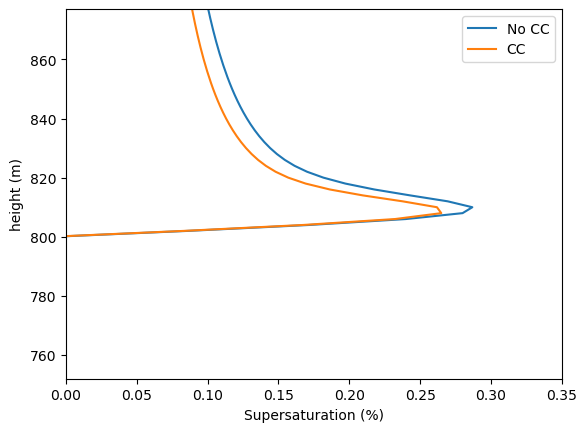

In [23]:
plt.plot(NoCC_ds['susa'],NoCC_ds['height'], label = 'No CC')
plt.plot(CC_ds['susa'],CC_ds['height'], label = 'CC')
plt.xlim([0,0.35])
plt.ylim([CBheight-50, CBheight+75])
plt.ylabel('height (m)')
plt.xlabel('Supersaturation (%)')
plt.legend()

(1e-08, 0.0001)

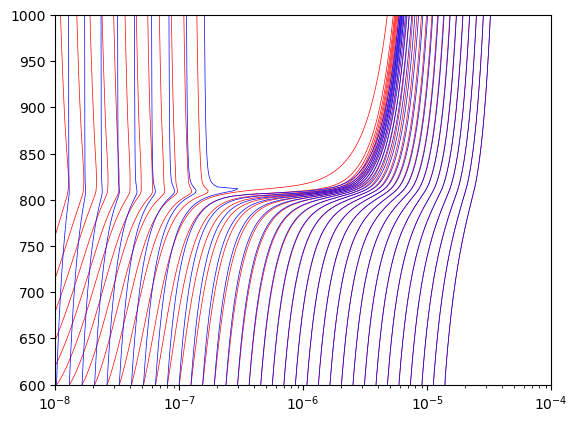

In [24]:
fig = plt.plot(CC_ds['rd'][:,0:None:10,0], CC_ds['height'], 'r-', linewidth = .5, label = 'With Co-Condensation')
plt.xscale('log')
fig = plt.plot(NoCC_ds['rd'][:,0:None:10,0], NoCC_ds['height'],'b-', linewidth = .5, label = 'Without Co-condensation')
plt.ylim([600,1000])
plt.xlim([1E-8, 1E-4])


In [25]:
SmaxCC = CC_ds['susa'].max()
indexSmaxCC = CC_ds['time_entries'].where(CC_ds['susa'].max())
Smax = NoCC_ds['susa'].max()
print( np.float64(SmaxCC), np.float64(Smax))

0.2648705196721569 0.2867939922295125


In [26]:
Sdelta = Smax -SmaxCC
Sdelta

<xarray.DataArray 'susa' ()> Size: 8B
np.float64(0.021923472557355606)

In [27]:
Rcrit = NoCC_ds['rcrit'].sel(time_entries = index).isel(num_aerosols = 0)
RD = NoCC_ds['rd'].sel(time_entries = index).isel(num_aerosols = 0)
RA = NoCC_ds['ra'].isel(time_entries = 0)

In [28]:
RcritCC = CC_ds['rcrit'].sel(time_entries = indexCC).isel(num_aerosols = 0)
RDCC = CC_ds['rd'].sel(time_entries = indexCC).isel(num_aerosols = 0)
RACC = CC_ds['ra'].isel(time_entries = 0)

In [29]:
RA_act_dry = np.min(RA.where(RD >= Rcrit))
RA_act_dryCC = np.min(RACC.where(RDCC >= RcritCC))

In [30]:
RA_act_dry_delta = RA_act_dry-RA_act_dryCC

In [31]:
RA_act_dry_delta

<xarray.DataArray 'ra' ()> Size: 8B
np.float64(8.490045985073036e-09)

In [32]:
ra_act = np.float64(NoCC_ds['ra_act'].sel(time_entries = index).isel(num_aerosols = 0, num_activation_criteria = 0))

In [33]:
ra_act

np.float64(40.56811308291239)

In [34]:
RA_act_dry

<xarray.DataArray 'ra' ()> Size: 8B
array(4.05681131e-08)

In [35]:
NoCC_ds['smax'].max()

<xarray.DataArray 'smax' ()> Size: 8B
array(0.28794728)

In [36]:
Smax

<xarray.DataArray 'susa' ()> Size: 8B
array(0.28679399)

In [37]:
CDNCNOCC = NoCC_ds['fa_act'].isel( num_activation_criteria = 2,num_aerosols_plus_3 = 0)
CDNCCC = CC_ds['fa_act'].isel( num_activation_criteria = 2,num_aerosols_plus_3 = 0)

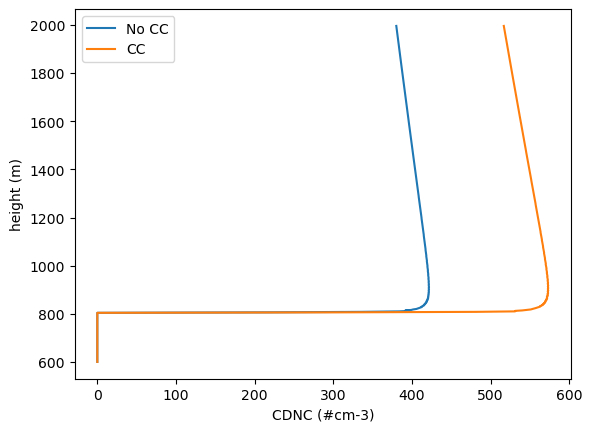

In [38]:
plt.plot(CDNCNOCC, NoCC_ds['height'], label = 'No CC')
plt.plot(CDNCCC, CC_ds['height'], label = 'CC')
plt.ylabel('height (m)')
plt.xlabel('CDNC (#cm-3)')
plt.legend()

Text(0.5, 0, 'D')

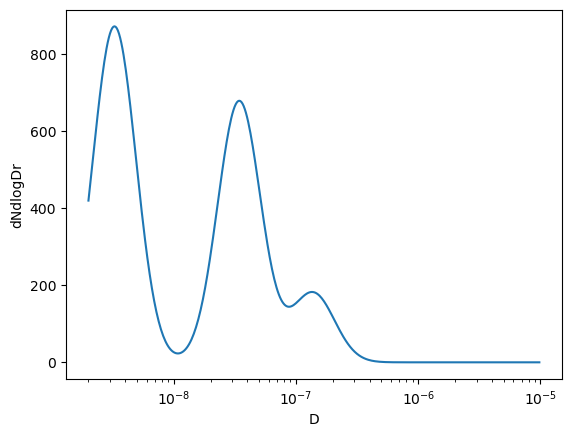

In [39]:
plt.plot(NoCC_ds['ra'].isel(time_entries = 0)[:-1],NoCC_ds['dNdlogDr'].isel(time_entries = 0).isel(num_aerosols = 0))
plt.xscale('log')
plt.ylabel('dNdlogDr')
plt.xlabel('D')
#plt.legend()         

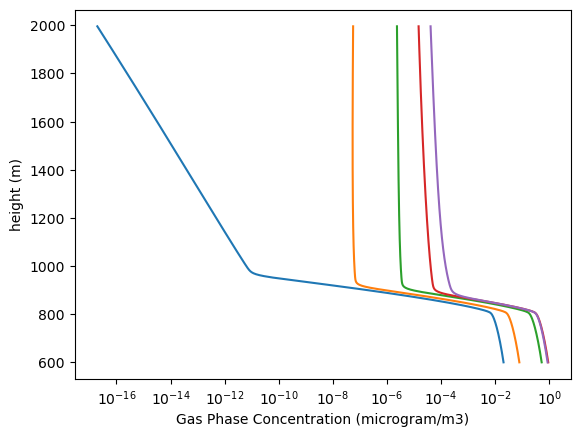

In [40]:
fig = plt.plot(CC_ds['vbs_gas_concentration'].isel(norg_plus1 = slice(0,5))*1E9, CC_ds['height'])
plt.xscale('log')
plt.xlabel('Gas Phase Concentration (microgram/m3)')
plt.ylabel('height (m)')
plt.savefig('plots/ECCCTest1.png')

In [41]:
CC_ds['vbs_gas_concentration']

<xarray.DataArray 'vbs_gas_concentration' (time_entries: 699, norg_plus1: 7)> Size: 39kB
[4893 values with dtype=float64]
Dimensions without coordinates: time_entries, norg_plus1
Attributes:
    units:        MISSING UNITS
    description:  MISSING DESCRIPTION

In [42]:
Initial = xr.open_dataset('/share/pech2273/PARSEC/ECEarth/EC6/CC/Updraft1/initial_parameters.nc')

In [43]:
Initial['part_coeff'].values

array([9.91909446e-01, 9.24585749e-01, 5.50765584e-01, 1.09211501e-01,
       1.21116039e-02, 1.22450807e-03, 1.55922168e-06])

In [44]:
Test_ =xr.open_dataset('/share/pech2273/PARSEC/ECEarth/EC1/CC/Updraft1/initial_parameters.nc')
Test =xr.open_dataset('/share/pech2273/PARSEC/ECEarth/EC2/CC/Updraft1/initial_parameters.nc')

In [45]:
Test_['part_coeff'].values

array([9.99590048e-01, 9.95915554e-01, 9.60603742e-01, 7.09159625e-01,
       1.96032398e-01, 2.38027366e-02, 1.14892565e-06])

In [46]:
Test['part_coeff'].values

array([9.97040652e-01, 9.71174269e-01, 7.71121106e-01, 2.52007770e-01,
       3.25931259e-02, 3.35780996e-03, 2.70154709e-06])